In [3]:
import cv2
import numpy as np
import glob
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Bidirectional

In [4]:

base_dir = r'C:\Users\venka\OneDrive\Desktop\Project\Dataset\Dataset_Signature_Final\Dataset'

# Gather paths for genuine signatures
gen_sign = []
for i in range(1, 5):  # Assuming you have datasets 1 to 4
    gen_sign.extend(glob.glob(base_dir + f'\\dataset{i}\\real\\*.*'))

# Gather paths for forged signatures
forg_sign = []
for i in range(1, 5):  # Assuming you have datasets 1 to 4
    forg_sign.extend(glob.glob(base_dir + f'\\dataset{i}\\forge\\*.*'))

print("Genuine Signatures:", len(gen_sign))
print("Forged Signatures:", len(forg_sign))


Genuine Signatures: 360
Forged Signatures: 360


In [5]:
train_ratio = 0.8

# Split genuine signatures into train and test
train_gen_sign = gen_sign[:int(len(gen_sign) * train_ratio)]
test_gen_sign = gen_sign[int(len(gen_sign) * train_ratio):]

# Split forged signatures into train and test
train_forg_sign = forg_sign[:int(len(forg_sign) * train_ratio)]
test_forg_sign = forg_sign[int(len(forg_sign) * train_ratio):]

# Combine paths for training and testing
train_image_paths = train_gen_sign + train_forg_sign
test_image_paths = test_gen_sign + test_forg_sign

print("Training Image Paths:", len(train_image_paths))
print("Testing Image Paths:", len(test_image_paths))


Training Image Paths: 576
Testing Image Paths: 144


In [6]:
def preprocess_image(image_path, img_size=(128, 128), patch_size=(128, 128)):  # Make img_size and patch_size same
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")
    
    img = cv2.resize(img, img_size)
    return img_to_patches(img, patch_size)


In [7]:
def img_to_patches(img, patch_size=(128, 128)):
    patches = []
    for i in range(0, img.shape[0], patch_size[0]): 
        for j in range(0, img.shape[1], patch_size[1]):
            patch = img[i:i+patch_size[0], j:j+patch_size[1]]
            patches.append(patch.flatten())  # Flatten the patch and append to list
    return np.array(patches)



In [8]:
def process_images(image_paths, label):
    X_data = []
    y_data = []
    
    for image_path in image_paths:
        try:
            if not os.path.exists(image_path):
                raise FileNotFoundError(f"Image path does not exist: {image_path}")
            
            # Preprocess the image
            patches = preprocess_image(image_path)
            X_data.append(patches)
            y_data.append(label)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
    
    return np.array(X_data), np.array(y_data)

In [9]:
# Process training data
X_train_real, y_train_real = process_images(train_gen_sign, label=0)  # Label 0 for real signatures
X_train_forg, y_train_forg = process_images(train_forg_sign, label=1)  # Label 1 for forged signatures

# Create test dataset
X_test_real, y_test_real = process_images(test_gen_sign, label=0)  # Label 0 for real signatures
X_test_forg, y_test_forg = process_images(test_forg_sign, label=1)  # Label 1 for forged signatures

# Combine and shuffle the training and testing data as needed
X_train = np.concatenate([X_train_real, X_train_forg], axis=0)
y_train = np.concatenate([y_train_real, y_train_forg], axis=0)

X_test = np.concatenate([X_test_real, X_test_forg], axis=0)
y_test = np.concatenate([y_test_real, y_test_forg], axis=0)

# Shuffle the training data
indices = np.random.permutation(len(X_train))
X_train = X_train[indices]
y_train = y_train[indices]

# Shuffle the test data
test_indices = np.random.permutation(len(X_test))
X_test = X_test[test_indices]
y_test = y_test[test_indices]




In [10]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (576, 1, 16384)
y_train shape: (576,)
X_test shape: (144, 1, 16384)
y_test shape: (144,)


In [11]:
timesteps = X_train.shape[1]
features = X_train.shape[2]
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


In [12]:
model = Sequential([
    Bidirectional(LSTM(64,return_sequences=False),input_shape=(timesteps,features)),
    Dense(64,activation='relu'),
    Dense(2,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128)              8421888   
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 8,430,274
Trainable params: 8,430,274
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.save('bi_rnn_signature_verification_model.h5')

In [17]:
history = model.fit(X_train,y_train,batch_size=32,epochs=50,validation_data=(X_test,y_test))

Epoch 1/50
18/18 [==============================] - 7s 65ms/step - loss: 0.7019 - accuracy: 0.5243 - val_loss: 0.6999 - val_accuracy: 0.5000
Epoch 2/50
18/18 [==============================] - 1s 54ms/step - loss: 0.7048 - accuracy: 0.5156 - val_loss: 0.6987 - val_accuracy: 0.5000
Epoch 3/50
18/18 [==============================] - 1s 53ms/step - loss: 0.6953 - accuracy: 0.5000 - val_loss: 0.6916 - val_accuracy: 0.4931
Epoch 4/50
18/18 [==============================] - 1s 42ms/step - loss: 0.6982 - accuracy: 0.4792 - val_loss: 0.6908 - val_accuracy: 0.5486
Epoch 5/50
18/18 [==============================] - 1s 56ms/step - loss: 0.6984 - accuracy: 0.4896 - val_loss: 0.6980 - val_accuracy: 0.5069
Epoch 6/50
18/18 [==============================] - 1s 42ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6920 - val_accuracy: 0.5000
Epoch 7/50
18/18 [==============================] - 1s 62ms/step - loss: 0.6919 - accuracy: 0.4861 - val_loss: 0.6900 - val_accuracy: 0.5486
Epoch 8/50
18

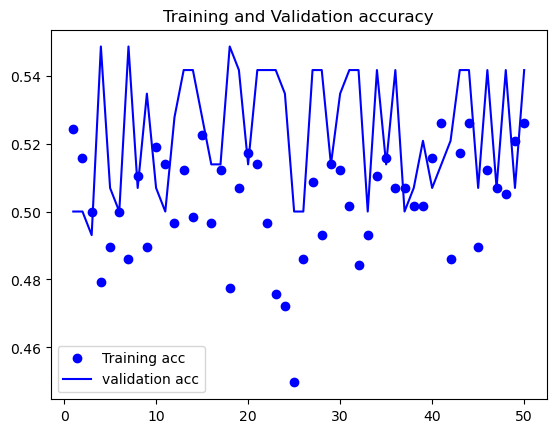

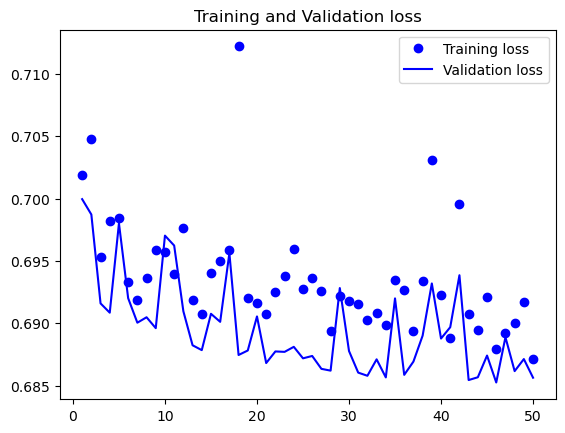

In [18]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [19]:
final_loss,final_accuracy = model.evaluate(X_test,y_test)
print('Final loss:{:.2f}%'.format(final_loss * 100))
print('Final Accuracy: {:.2f}%'.format(final_accuracy*100))

5/5 [==============================] - 0s 32ms/step - loss: 0.6856 - accuracy: 0.5417
Final loss:68.56%
Final Accuracy: 54.17%


1/1 [==============================] - 0s 27ms/step


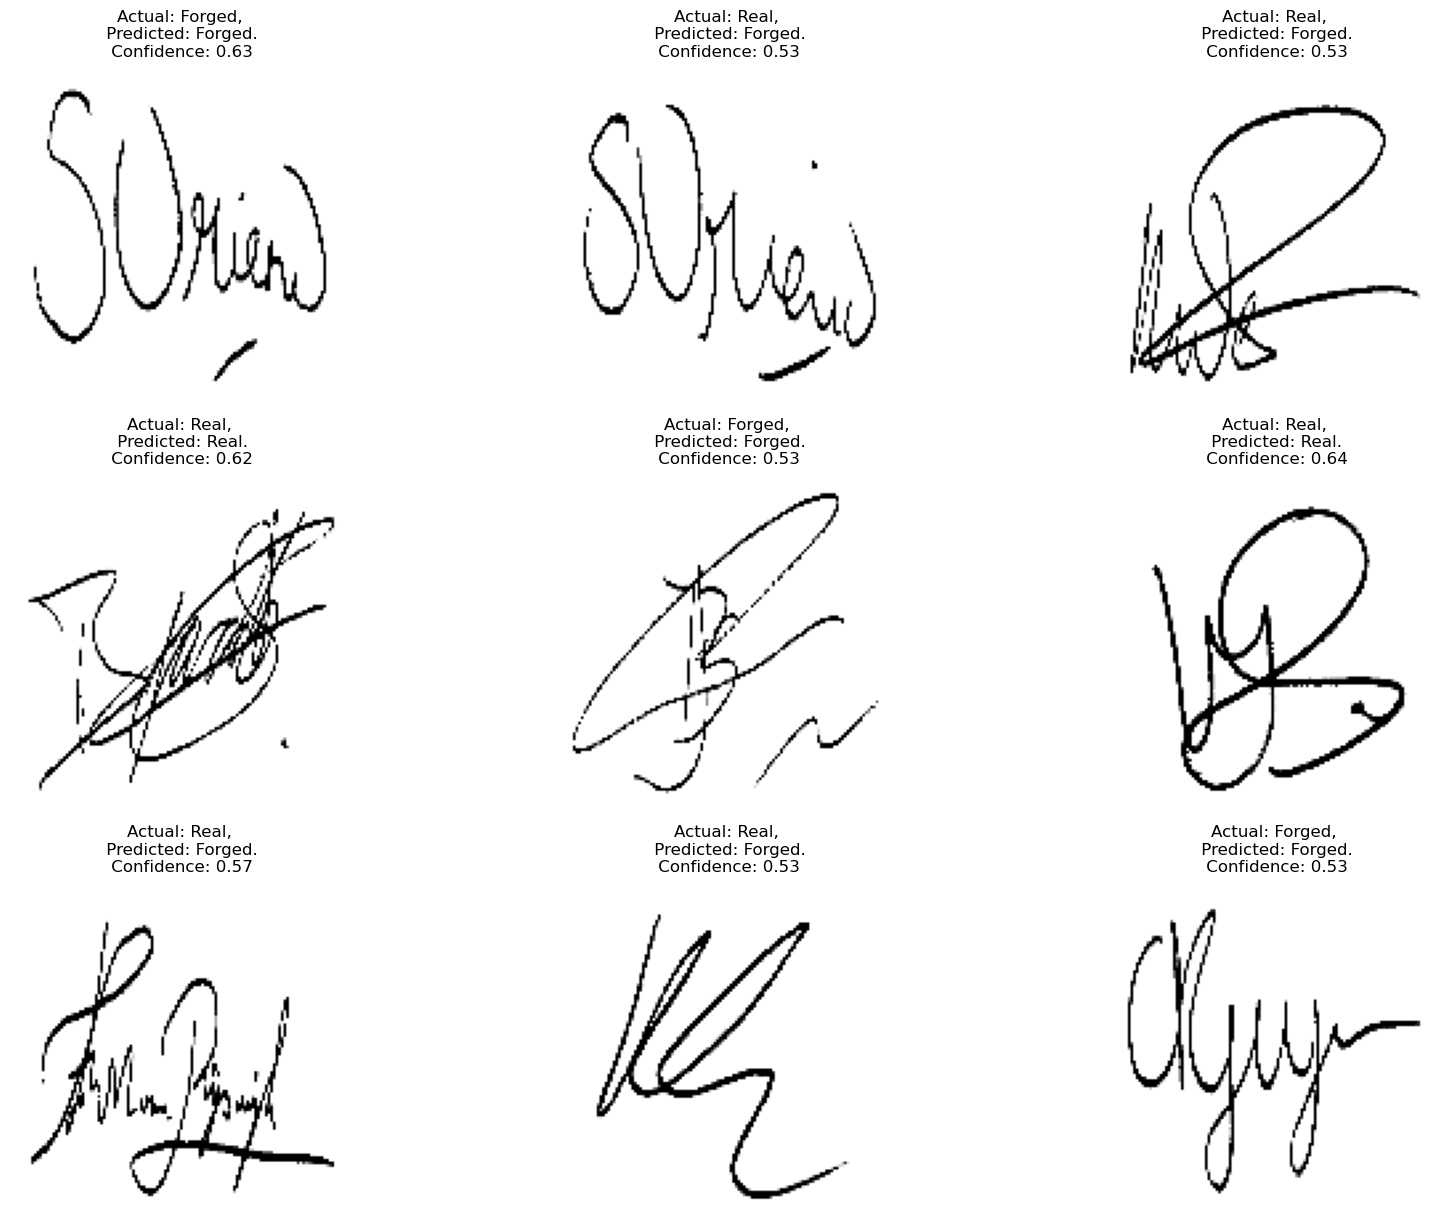

In [20]:
import matplotlib.pyplot as plt
 
# Assuming X_test is a numpy array and you want to visualize the first 9 images
plt.figure(figsize=(20, 15))
 
# Loop over the first 9 images and their labels
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    image = X_test[i].reshape(128, 128)  # Reshape the patches back to the original image shape
    plt.imshow(image, cmap='gray')  # Display the image
    # Predict the class and confidence
    predicted_class = np.argmax(model.predict(np.expand_dims(X_test[i], axis=0)))  # Predict the class
    confidence = np.max(model.predict(np.expand_dims(X_test[i], axis=0)))  # Get the confidence score
    actual_class = np.argmax(y_test[i])  # Get the actual class from y_test
    class_names = ['Real', 'Forged']  # Class names
    plt.title(f'Actual: {class_names[actual_class]},\n Predicted: {class_names[predicted_class]}.\n Confidence: {confidence:.2f}')
    plt.axis('off')
plt.show()
 
 